
<h1 id="Template-Matching">Template Matching<a class="anchor-link" href="#Template-Matching"></a></h1> <br>


<font color = 'orange'>_Sudarsanan A K_ <br>
_SC21M063_ </font>


<h2 id="Lesson-Plan">Lesson Plan<a class="anchor-link" href="#Lesson-Plan"></a></h2><ul>
<li>Sum of squared differences</li>
<li>Normalized sum of squared differences</li>
<li>Cross-correlation</li>
<li>Normalized cross-correlation</li>
<li>Correlation coefficient</li>
<li>Normalized correlation coefficient</li>
</ul>



<h2 id="Where-is-waldo?">Where is waldo?<a class="anchor-link" href="#Where-is-waldo?"></a></h2><p>Our task is to find Waldo</p>
<center>
<tr>
<td><img src="https://drive.google.com/uc?id=1o3tDbOj6A_N1GaMkVm2bwvufQM6w8R9T" width="15%"/></td>
</tr>
</center><p>in the crowd</p>
<center>
<tr>
<td><img src="https://drive.google.com/uc?id=12FlMiizwPG567uVcETk9luZ3H8E5Qg-2" width="95%"/></td>
</tr>
</center>



<h3 id="Key-insight">Key insight<a class="anchor-link" href="#Key-insight"></a></h3><p><strong>Compare</strong> patches in the image with Waldo's picture.  In order to do so, we need to be able determine if patch 1 is more similar to patch 2 or patch 3 (as shown in the figure below).</p>
<center>
<tr>
<td><img src="https://drive.google.com/uc?id=1vYOdzSb7VKISQpGxnS-0duoNv7cbOQGg" width="65%"/></td>
</tr>
</center>



<h3 id="Template-Matching">Template Matching<a class="anchor-link" href="#Template-Matching"></a></h3><p>Given a source image $I$ and a template $T$, we compare the template image against the source image by sliding it one pixel at a time (left to right, top to bottom) and computing a similarity (or alternately difference) between template and the image patch at each location.  The similarity scores is computed using a suitable function $g(T, I, i, j) \mapsto R(i,j)$, where $R(i,j)$ is the similarity score for between the template and the image patch at location $(i,j)$.  Location corresponding to highest (or alternately lowest) value in the result matrix $R$ represent the "match location."</p>
<p>A common trick is to treat both the template and patches as vectors in a high-dimensional space.  Template-patch-matching problem is then reduced to finding the nearest vector (in this high-dimensional space).</p>



<h2 id="Picking-image-patches">Picking image patches<a class="anchor-link" href="#Picking-image-patches"></a></h2>


In [1]:

import cv2 as cv
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt


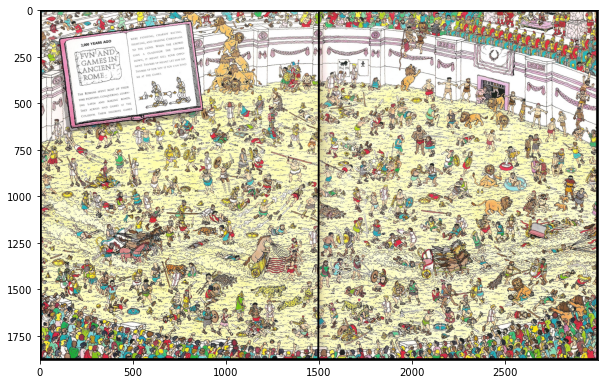

In [4]:


I = cv.imread('06-data/where-is-waldo.jpg')
I = cv.cvtColor(I, cv.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(I);




#### Exercise : Lets pick a patch from this image


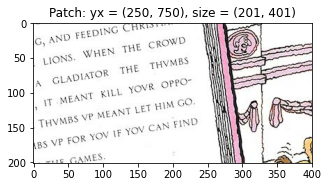

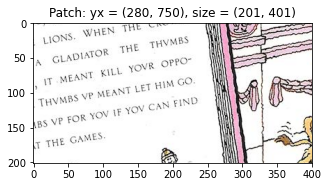

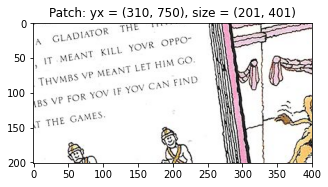

In [5]:

y, x = 250, 750
half_h, half_w = 100, 200

def pick_patch(I, y, x, half_h, half_w):
    #############################################################
    # I - Source Image
    # (y,x) - Center of the patch to be picked
    # (2*half_h, 2*half_w) - Size of the patch to be picked
    
    # Write your solution here (~1 line of code)
    #############################################################
    return I[y-half_h : y+half_h+1, x-half_w : x+half_w+1, :]
    #############################################################

for yi in range(3):
    for xi in range(1):
        x_ = x + 30 * xi
        y_ = y + 30 * yi
        patch = pick_patch(I, y_, x_, half_h, half_w)
        fig = plt.figure(figsize=(5,5))
        plt.imshow(patch)
        plt.title('Patch: yx = {}, size = {}'.format((y_,x_), patch.shape[:2]))
        plt.show()



(103, 71, 3)


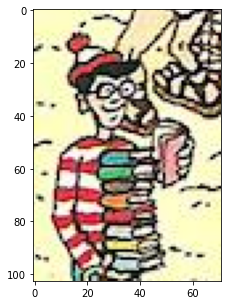

In [10]:

template = cv.imread('06-data/waldo.png')
template = cv.cvtColor(template, cv.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(template);
print(np.shape(template))


#### Exercise : Intuition for Comparing Patches

- Flatten the `template` into a vector.
- Pick a patch from source image `I` (Hint: Use `pick_patch()` function) $\rightarrow$ `(y,x) = (300,400)`; `(half_h,half_w) = (15,15)`
- Flatten the `patch` into a vector and print the sizes of `template` and `patch`


In [11]:

#############################################################
# Write your Solution here (3-4 lines of code)
#############################################################
template = template.flatten()
patch = pick_patch(I, 300, 400, 15, 15).flatten()
print('Template size = {}'.format(template.size))
print('Patch size = {}'.format(patch.size))
#############################################################

Template size = 21939
Patch size = 2883




<p><strong> Question</strong> : Are the sizes of template and patch same? If not, can we compare the two vectors?</p>
<p><strong>Your Answer </strong>: </p> The template and patch obtained above have different sizes. So it is not possible to compare the corresponding vectors



<h2 id="Techniques-for-comparing-patches">Techniques for comparing patches<a class="anchor-link" href="#Techniques-for-comparing-patches"></a></h2><p>We now discuss methods for comparing image patches (and templates).  The following discussion assumes that patches (and templates) have the same dimensions (<em>observation 1 above</em>).  We also use the following notation:</p>
<ul>
<li>Template: $T$</li>
<li>Image: $I$</li>
<li>Image patch centered at $(i,j)$: $I(i+k, j+l)$</li>
<li>Response: $R$</li>
</ul>
<p><em>Aside</em>:</p>
<p>For OpenCV Template Matching function if image is $W \times H$ and template is $w \times h$ then result $R$ is $(W-w+1) \times (H-h+1)$.</p>


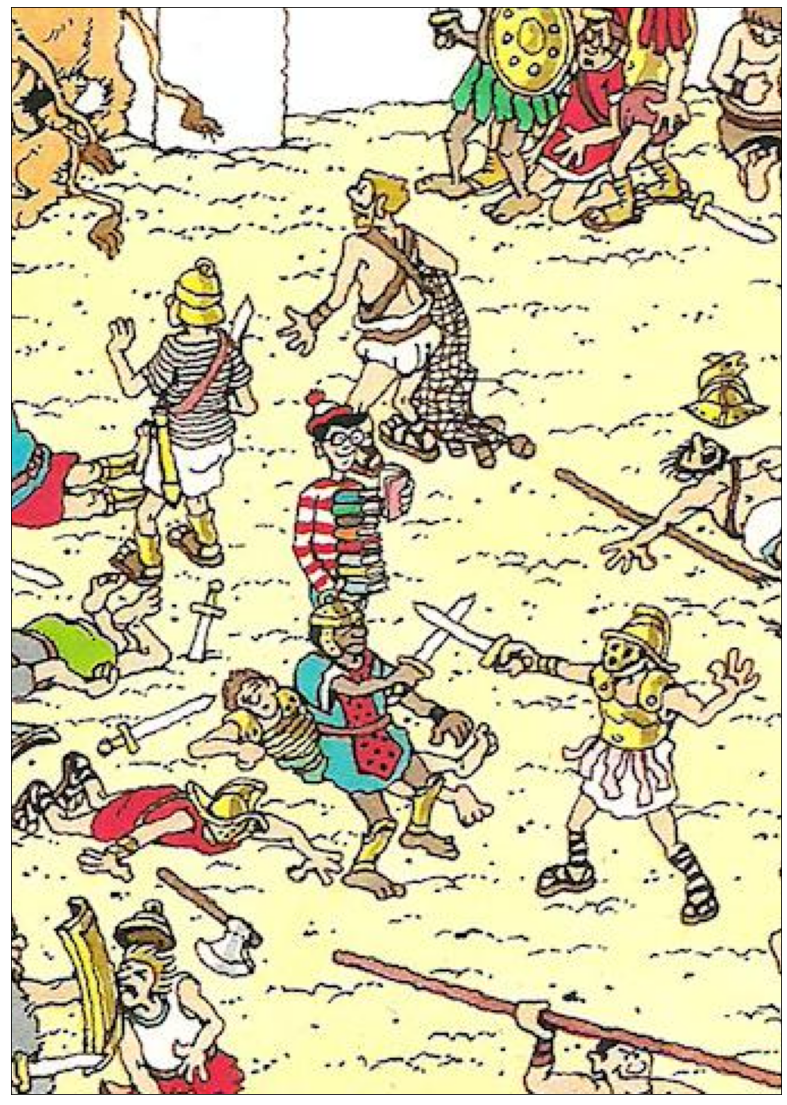

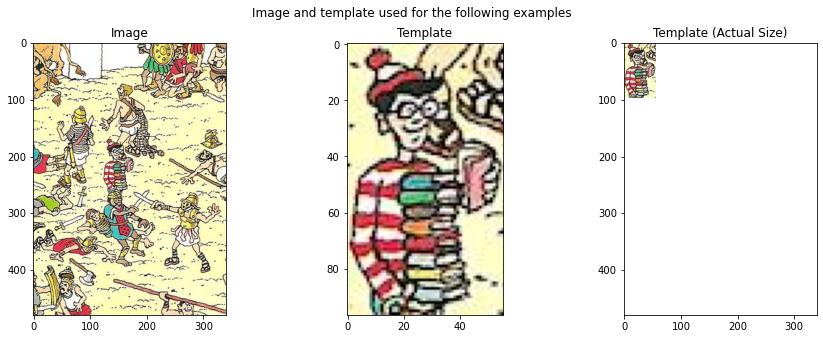

In [13]:

def highlight(R, T, I, use_max=True):
    W, H = I.shape[0], I.shape[1]
    w, h = T.shape[0], T.shape[1]
    wr, hg = R.shape[0], R.shape[1]
    print(W,H)
    print(w,h)
    print(wr,hg)
        
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(R)
    loc = max_loc if use_max else min_loc
    loc = loc + np.array([h//2, w//2])               # Size of R is different from I 
    tl = loc - np.array([h//2, w//2])
    br = loc + np.array([h//2, w//2])
    I_ = np.copy(I)
    c = (1.0, 0, 0) if I_.dtype == 'float32' else (255, 0, 0)
    print(c)
    print(tl)
    print(br)
    cv.rectangle(I_, tuple(tl), tuple(br), c, 4)
    return I_

# Image
img_waldo = cv.imread('06-data/where-is-waldo.jpg')
img_waldo = cv.cvtColor(img_waldo, cv.COLOR_BGR2RGB)
img_waldo_zoomed = img_waldo[344:824, 1100:1440, :]
img = cv.cvtColor(img_waldo_zoomed, cv.COLOR_RGB2GRAY)
plt.figure(figsize=(20,20))
plt.imshow(img_waldo_zoomed)
plt.xticks([])
plt.yticks([])

# Template
waldo = img_waldo_zoomed[167:264,123:179,:]
template = cv.cvtColor(waldo, cv.COLOR_RGB2GRAY)
foo = np.ones(img_waldo_zoomed.shape, dtype=img_waldo_zoomed.dtype)*255
foo[0:waldo.shape[0],0:waldo.shape[1],:] = waldo

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Image')
plt.imshow(img_waldo_zoomed)
plt.subplot(132)
plt.title('Template')
plt.imshow(waldo)
plt.subplot(133)
plt.title('Template (Actual Size)')
plt.imshow(foo)
plt.suptitle('Image and template used for the following examples');




<h2 id="Sum-of-Squared-Differences-(SSD)">Sum of Squared Differences (SSD)<a class="anchor-link" href="#Sum-of-Squared-Differences-(SSD)"></a></h2>$$
R(i,j) = \sum_{k,l} \left( I(i+k, j+l) - T(k,l)  \right)^2
$$<p>Here $R(i,j)$ encodes the distance between the template and image patch centered at image location $(i,j)$.  The smaller this value, the more similar is template to the patch.</p>
<p>SSD is sensitive to average intensity.</p>


480 340
97 56
384 285
(255, 0, 0)
[123 167]
[179 263]


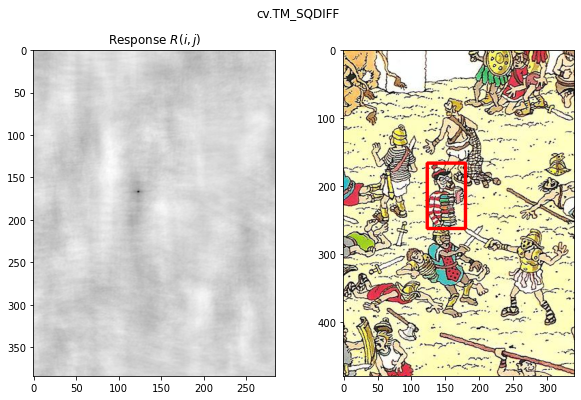

In [14]:

T = template.copy()
I = img.copy()

method = 'cv.TM_SQDIFF'
R = cv.matchTemplate(I, T, eval(method))
I_ = highlight(R, T, img_waldo_zoomed, use_max=False)

plt.figure(figsize=(10,6))
plt.subplot(121)
plt.title('Response $R(i,j)$')
plt.imshow(R, cmap = 'gray')
plt.subplot(122)
plt.imshow(I_)
plt.suptitle(method)
plt.show()




<h2 id="Sum-of-Squared-Differences-Normalized-(SSD)">Sum of Squared Differences Normalized (SSD)<a class="anchor-link" href="#Sum-of-Squared-Differences-Normalized-(SSD)"></a></h2>$$
R(i,j) = 
\frac{\sum_{k,l} \left( I(i+k, j+l) - T(k,l)  \right)^2}
{\sqrt{\sum_{k,l} I(i+k, j+l)^2 \sum_{k,l} T(k,l)^2}}
$$<p>The smaller this value, the more similar is template to the patch.</p>


480 340
97 56
384 285
(255, 0, 0)
[123 167]
[179 263]


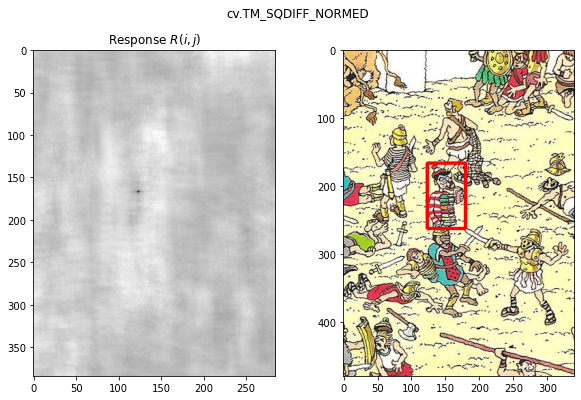

In [19]:
T = template.copy()
I = img.copy()


#############################################################
# R - Response Map obtained after comparing the template and patch

# Compare using the Sum of Squared Differences Normalized metric and 
# display the highlighted template in source

# Write your Solution here (3 lines of code)
# Hint : Use "cv.TM_SQDIFF_NORMED" 
#############################################################

method = 'cv.TM_SQDIFF_NORMED'
R = cv.matchTemplate(I, T, eval(method))
I_ = highlight(R, T, img_waldo_zoomed, use_max=False)

#############################################################


plt.figure(figsize=(10,6))
plt.subplot(121)
plt.title('Response $R(i,j)$')
plt.imshow(R, cmap = 'gray')
plt.subplot(122)
plt.imshow(I_)
plt.suptitle(method)
plt.show()




<h2 id="Correlation-Coefficient-Definition">Correlation Coefficient Definition<a class="anchor-link" href="#Correlation-Coefficient-Definition"></a></h2><p>A measure of the degree to which the movement of two random variables are associated</p>
$$
\rho_{xy} = \frac{\mathrm{cov}(x,y)}{\sigma_x \sigma_y}
$$<p>where</p>
<p>$\mathrm{cov}(x,y) = \mathrm{E}[(x - \mu_x)(y - \mu_x)] $ is covariance of random variables $x$ and $y$, and $\mu_x$, $\mu_y$, $\sigma_x$ and $\sigma_y$ are, respectively, their means and standard deviations.</p>



<h2 id="Correlation-Coefficient">Correlation Coefficient<a class="anchor-link" href="#Correlation-Coefficient"></a></h2>$$
R(i,j) = \sum_{k,l} I'(i+k, j+l) T'(k, l)
$$<p>where</p>
$$
\begin{align}
I' &amp;= I - \frac{1}{wh} \sum_{k',l'} I(i+k',j+l') \\
T' &amp;= T - \frac{1}{wh} \sum_{k',l'} T(k',l')
\end{align}
$$<p>$w$ and $h$ refer to the width and height of template $T$.</p>


480 340
97 56
384 285
(255, 0, 0)
[123 167]
[179 263]


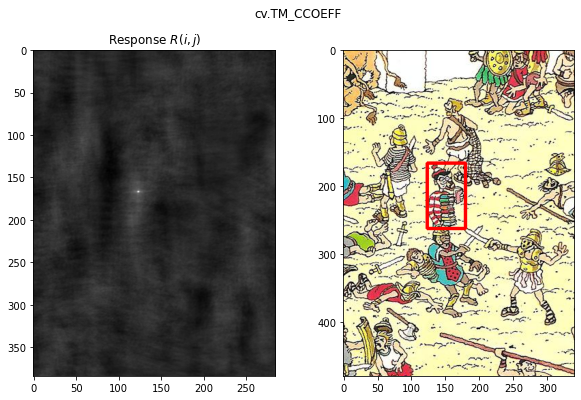

In [17]:

T = template.copy()
I = img.copy()


method = 'cv.TM_CCOEFF'
R = cv.matchTemplate(I, T, eval(method))
I_ = highlight(R, T, img_waldo_zoomed, use_max=True)

plt.figure(figsize=(10,6))
plt.subplot(121)
plt.title('Response $R(i,j)$')
plt.imshow(R, cmap = 'gray')
plt.subplot(122)
plt.imshow(I_)
plt.suptitle(method)
plt.show()




<h2 id="Correlation-Coefficient-Normalized">Correlation Coefficient Normalized<a class="anchor-link" href="#Correlation-Coefficient-Normalized"></a></h2>$$
R(i,j) = 
\frac{\sum_{k,l} I'(i+k, j+l) T'(k, l)}
{\sqrt{\sum_{k,l}I'(i+k, j+l)^2 \sum_{k,l} T'(k,l)^2}}
$$<p>where</p>
$$
\begin{align}
I' &amp;= I - \frac{1}{wh} \sum_{k',l'} I(i+k',j+l') \\
T' &amp;= T - \frac{1}{wh} \sum_{k',l'} T(k',l')
\end{align}
$$<p>$w$ and $h$ refer to the width and height of template $T$.</p>
<p>Invariant to mean and scale of intensity.</p>


480 340
97 56
384 285
(255, 0, 0)
[123 167]
[179 263]


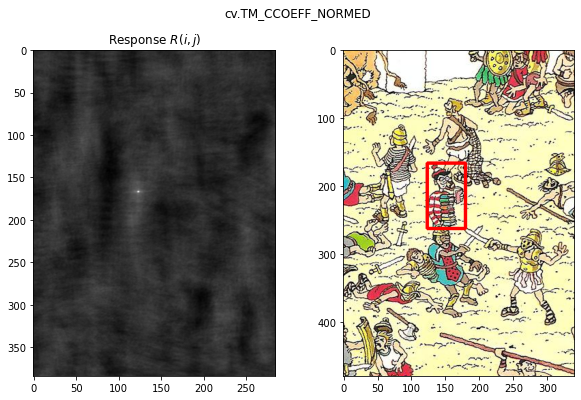

In [25]:

T = template.copy()
I = img.copy()

#############################################################
# R - Response Map obtained after comparing the template and patch

# Compare using the Correlation Coefficient Normalized metric and 
# display the highlighted template in source

# Write your Solution here (3 lines of code)
# Hint : Use "cv.TM_CCOEFF_NORMED" 
#############################################################
method = 'cv.TM_CCOEFF_NORMED'
R = cv.matchTemplate(I, T, eval(method))
I_ = highlight(R, T, img_waldo_zoomed, use_max=True)
#############################################################

plt.figure(figsize=(10,6))
plt.subplot(121)
plt.title('Response $R(i,j)$')
plt.imshow(R, cmap = 'gray')
plt.subplot(122)
plt.imshow(I_)
plt.suptitle(method)
plt.show()




<h2 id="Cross-Correlation">Cross-Correlation<a class="anchor-link" href="#Cross-Correlation"></a></h2>$$
R(i,j) = \sum_{k,l} I(i+k, j+l)  T(k, l)
$$<p>Response is stronger for higher intensities, which leads to <em>false positive</em>.  Recall that cross-correlation can be implemented as <em>linear filtering</em>.</p>


480 340
97 56
384 285
(255, 0, 0)
[232 113]
[288 209]


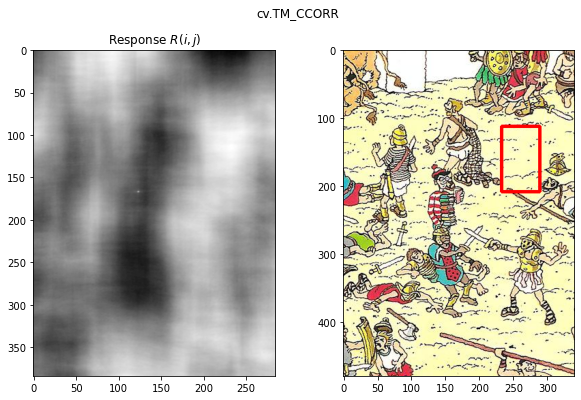

In [26]:

T = template.copy()
I = img.copy()

method = 'cv.TM_CCORR'
R = cv.matchTemplate(I, T, eval(method))
I_ = highlight(R, T, img_waldo_zoomed, use_max=True)

plt.figure(figsize=(10,6))
plt.subplot(121)
plt.title('Response $R(i,j)$')
plt.imshow(R, cmap = 'gray')
plt.subplot(122)
plt.imshow(I_)
plt.suptitle(method)
plt.show()




<h2 id="Normalized-Cross-Correlation">Normalized Cross Correlation<a class="anchor-link" href="#Normalized-Cross-Correlation"></a></h2>$$
R(i,j) = 
\frac{\sum_{k,l} I(i+k, j+l)  T(k, l)}
{\sqrt{\sum_{k,l} I(i+k, j+l)^2 \sum_{k,l} T(k, l)^2}}
$$


480 340
97 56
384 285
(255, 0, 0)
[123 167]
[179 263]


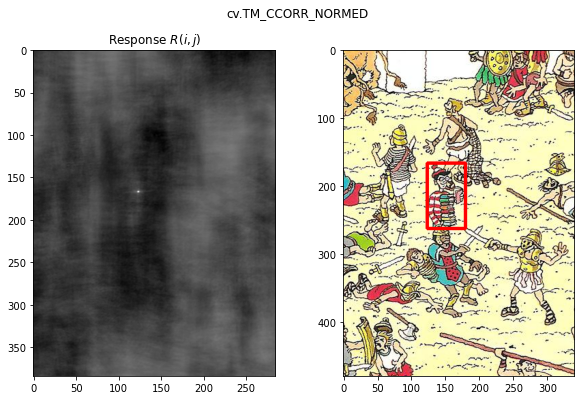

In [27]:

T = template.copy()
I = img.copy()

#############################################################
# R - Response Map obtained after comparing the template and patch

# Compare using the Normalized Cross Correlation metric and 
# display the highlighted template in source

# Write your Solution here (3 lines of code)
# Hint : Use "cv.TM_CCORR_NORMED" 
#############################################################
method = 'cv.TM_CCORR_NORMED'
R = cv.matchTemplate(I, T, eval(method))
I_ = highlight(R, T, img_waldo_zoomed, use_max=True)
#############################################################

plt.figure(figsize=(10,6))
plt.subplot(121)
plt.title('Response $R(i,j)$')
plt.imshow(R, cmap = 'gray')
plt.subplot(122)
plt.imshow(I_)
plt.suptitle(method)
plt.show()




<h2 id="Scale-considerations">Scale considerations<a class="anchor-link" href="#Scale-considerations"></a></h2><p>Thus far, we have assumed that template is the same size (i.e., similar scale) as the target object in the image.  Notice that "waldo" template has the same size (i.e., height and width) as the size of "waldo" seen in the image.  What would happen if the we relax this assumption?</p>


Text(0.5, 0.98, 'Image and template used for the following examples')

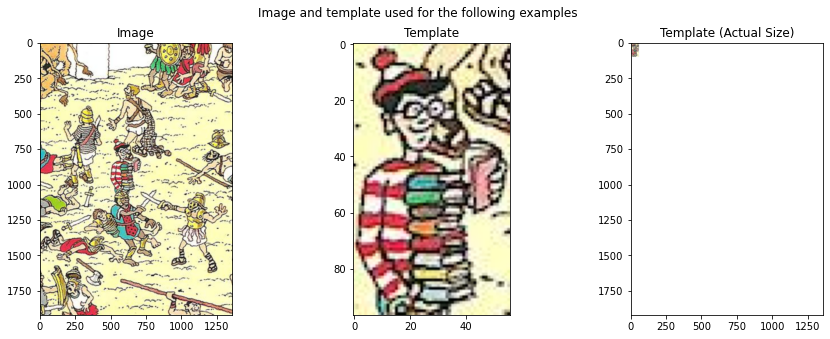

In [28]:

# Image
scale = 4
img_waldo = cv.imread('06-data/where-is-waldo.jpg')
img_waldo = cv.cvtColor(img_waldo, cv.COLOR_BGR2RGB)
img_waldo_zoomed = img_waldo[344:824, 1100:1440, :]
H, W = img_waldo_zoomed.shape[0], img_waldo_zoomed.shape[1]
img_waldo_resized = cv.resize(img_waldo_zoomed, (int(W*scale),int(H*scale)))
img = cv.cvtColor(img_waldo_resized, cv.COLOR_RGB2GRAY)

# Template
waldo = img_waldo_zoomed[167:264,123:179,:]
template = cv.cvtColor(waldo, cv.COLOR_RGB2GRAY)
foo = np.ones(img_waldo_resized.shape, dtype=img_waldo_resized.dtype)*255
foo[0:waldo.shape[0],0:waldo.shape[1],:] = waldo

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Image')
plt.imshow(img_waldo_resized)
plt.subplot(132)
plt.title('Template')
plt.imshow(waldo)
plt.subplot(133)
plt.title('Template (Actual Size)')
plt.imshow(foo)
plt.suptitle('Image and template used for the following examples')




<p>Lets perform template matching to find waldo.</p>


1920 1360
97 56
1824 1305
(255, 0, 0)
[  48 1292]
[ 104 1388]


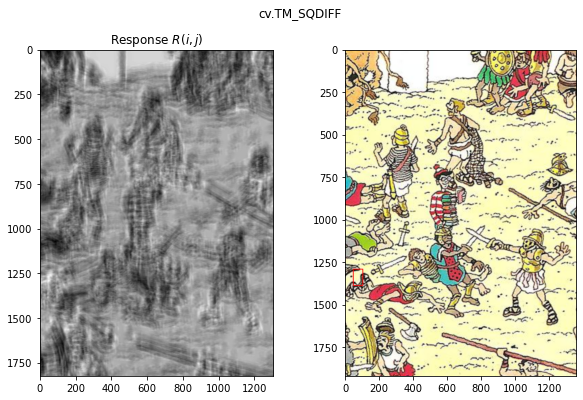

In [29]:

T = template.copy()
I = img.copy()

methods = ['cv.TM_CCOEFF', 
           'cv.TM_CCOEFF_NORMED', 
           'cv.TM_CCORR',
           'cv.TM_CCORR_NORMED', 
           'cv.TM_SQDIFF', 
           'cv.TM_SQDIFF_NORMED']

method = methods[4]
R = cv.matchTemplate(I, T, eval(method))
I_ = highlight(R, T, img_waldo_resized, use_max=True)

plt.figure(figsize=(10,6))
plt.subplot(121)
plt.title('Response $R(i,j)$')
plt.imshow(R, cmap = 'gray')
plt.subplot(122)
plt.imshow(I_)
plt.suptitle(method)
plt.show()




<p><strong>Observation 2</strong>: Template matching is not scale invariant.</p>
<p>We need to perform scale space analysis for template matching.  In other words, we need to use image pyramids: construct an image pyramid, perform template matching at each scale, find the correct scale and location within that scale using maxima (minima) search.</p>


### BONUS QUESTION : Other-Considerations
<strong> (Not Graded) </strong>

Is template matching rotation invariant?  What about occlusions?  What about shifts in color?</p>


Template matching is not rotation invariant. It is neither invariant to occlusion nor to shifts in color 